In [4]:
# 01_eda.ipynb — Block 1
# imports + load data

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# make sure figures folder exists
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# load raw csvs
invoices = pd.read_csv("../data/raw/client_invoices.csv")
clients = pd.read_csv("../data/raw/client_master.csv")

print("✅ files loaded")
print("invoices:", invoices.shape, "| clients:", clients.shape)

# quick peek
display(invoices.head(3))
display(clients.head(3))


✅ files loaded
invoices: (1800, 11) | clients: (54, 7)


,invoice_id,invoice_date,payment_due_date,payment_actual_date,invoice_amount,client_id,client_name,material_name,payment_method,delay_days,delayed_flag
0,INV00001,2024-05-20,2024-06-14,2024-06-21,660906,C036,Motherson Global Manufacturing Service - A div...,HR Coils,NEFT,7,1
1,INV00002,2024-12-04,2024-12-19,2025-01-04,188555,C024,HAMTEK TECHNOLOGIES INDIA PVT. LTD.,Galvanized Sheets,LC,16,1
2,INV00003,2024-02-21,2024-04-06,2024-04-04,237375,C015,COMMITTED ISPAT PRIVATE LIMITED,Binding Wire,RTGS,-2,0


,client_id,client_name,past_transaction_count,total_past_value,previous_delays_pct,avg_delay_days,on_time_pct
0,C001,ACRON INTERNATIONAL PRIVATE LIMITED,40,6177788,25.00,-1.050000,75.00
1,C002,AJAY INDUSTRIAL CORPORATION LTD,28,4868977,21.43,-1.678571,78.57
2,C003,AMAN POLY PLAST PVT. LTD,35,18692419,34.29,-0.142857,65.71


delay recompute mismatches: 0 (should be 0)

class balance (%):
delayed_flag
0    78.56
1    21.44
Name: proportion, dtype: float64


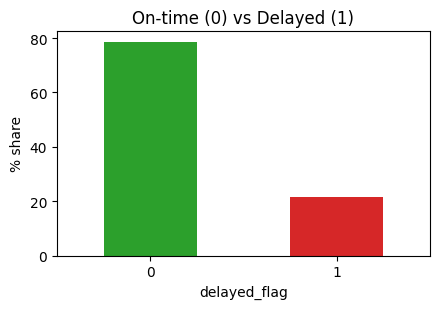

In [5]:
# 01_eda.ipynb — Block 2
# parse dates + recompute delays (sanity check)

date_cols = ["invoice_date", "payment_due_date", "payment_actual_date"]
for c in date_cols:
    invoices[c] = pd.to_datetime(invoices[c], errors="coerce")

# recompute to verify
invoices["delay_days_chk"] = (invoices["payment_actual_date"] - invoices["payment_due_date"]).dt.days
invoices["delayed_flag_chk"] = (invoices["delay_days_chk"] > 0).astype(int)

mismatch = (invoices["delay_days"] != invoices["delay_days_chk"]).sum() \
         + (invoices["delayed_flag"] != invoices["delayed_flag_chk"]).sum()
print(f"delay recompute mismatches: {mismatch} (should be 0)")

# target distribution
cb = invoices["delayed_flag"].value_counts(normalize=True).sort_index() * 100
print("\nclass balance (%):")
print(cb.round(2))

# simple plot
plt.figure(figsize=(4.5,3.2))
cb.plot(kind="bar", color=["#2ca02c", "#d62728"])
plt.title("On-time (0) vs Delayed (1)")
plt.xticks(rotation=0)
plt.ylabel("% share")
plt.tight_layout()
plt.savefig(FIG_DIR / "class_balance.png", dpi=150)
plt.show()


Date coverage: 2023-01-02 → 2025-08-31


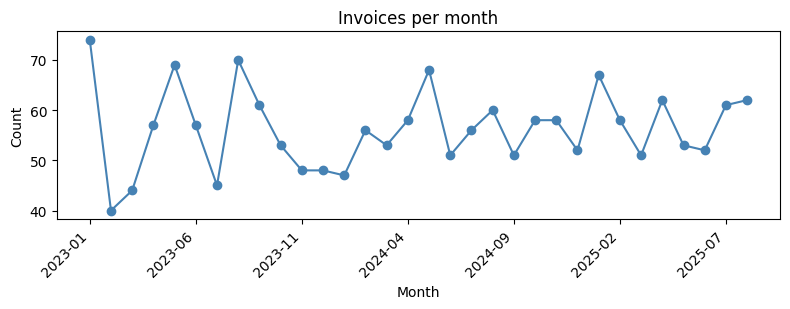

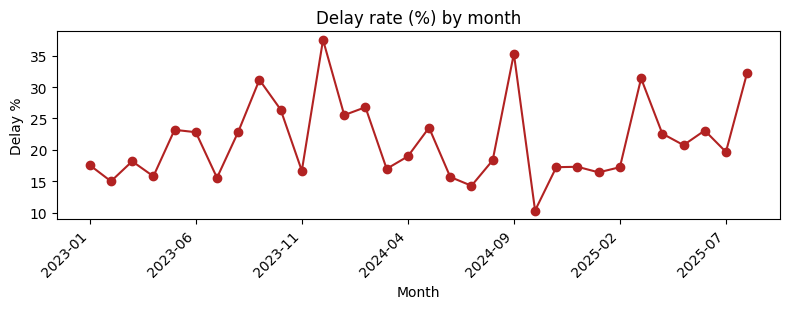

In [6]:
# 01_eda.ipynb — Block 3
# invoice volumes and delay % over time

# create a month column (YYYY-MM format)
invoices["month"] = invoices["invoice_date"].dt.to_period("M").astype(str)

# time span check
span = (invoices["invoice_date"].min(), invoices["invoice_date"].max())
print("Date coverage:", span[0].date(), "→", span[1].date())

# invoices per month
ipm = invoices.groupby("month")["invoice_id"].count()

plt.figure(figsize=(8,3.2))
ipm.plot(kind="line", marker="o", color="steelblue")
plt.title("Invoices per month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "invoices_per_month.png", dpi=150)
plt.show()

# delay rate by month
drm = invoices.groupby("month")["delayed_flag"].mean() * 100

plt.figure(figsize=(8,3.2))
drm.plot(kind="line", marker="o", color="firebrick")
plt.title("Delay rate (%) by month")
plt.xlabel("Month")
plt.ylabel("Delay %")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "delay_rate_by_month.png", dpi=150)
plt.show()


Top clients by average delay (days):


,client_name,n,avg_delay_days,delay_rate_pct,value
4,AMPP AUTO ACCESSORIES PRIVATE LIMITED,35,1.685714,42.86,5163349
37,NSC PROJECTS PVT LTD,23,1.652174,47.83,7959792
26,HI TECH SUPPORTS AND HANGERS PRIVATE LIMITED,31,0.677419,41.94,34518001
10,Chetak Industrial Agencies,25,0.560000,48.00,13589103
6,ARDEE ENGINEERING LIMITED,34,0.529412,47.06,5811899
23,HAMTEK TECHNOLOGIES INDIA PVT. LTD.,30,-0.066667,33.33,9240335
42,RAJVIR CHAUDHARY CONSTRUCTION PRIVATE LIMITED,42,-0.071429,40.48,6747259
44,RMN lnfrastructures Ltd,26,-0.115385,23.08,4169259
2,AMAN POLY PLAST PVT. LTD,35,-0.142857,34.29,18692419
15,D P JAIN & CO INFRASTRUCTURE PVT LTD,34,-0.529412,32.35,19308512



Top clients by delay frequency (% of invoices delayed):


,client_name,n,avg_delay_days,delay_rate_pct,value
10,Chetak Industrial Agencies,25,0.560000,48.00,13589103
37,NSC PROJECTS PVT LTD,23,1.652174,47.83,7959792
6,ARDEE ENGINEERING LIMITED,34,0.529412,47.06,5811899
4,AMPP AUTO ACCESSORIES PRIVATE LIMITED,35,1.685714,42.86,5163349
26,HI TECH SUPPORTS AND HANGERS PRIVATE LIMITED,31,0.677419,41.94,34518001
42,RAJVIR CHAUDHARY CONSTRUCTION PRIVATE LIMITED,42,-0.071429,40.48,6747259
2,AMAN POLY PLAST PVT. LTD,35,-0.142857,34.29,18692419
23,HAMTEK TECHNOLOGIES INDIA PVT. LTD.,30,-0.066667,33.33,9240335
48,SHAKTIMAN PACKAGING PVT LTD,37,-0.567568,32.43,12017718
15,D P JAIN & CO INFRASTRUCTURE PVT LTD,34,-0.529412,32.35,19308512


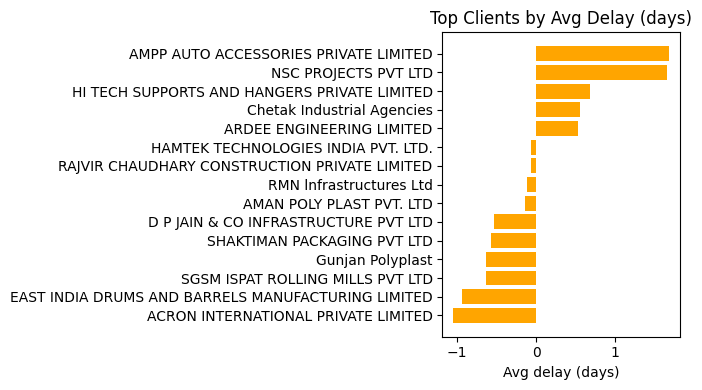

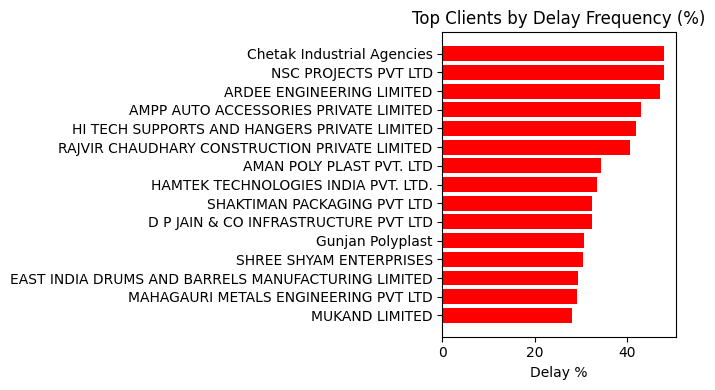

In [7]:
# 01_eda.ipynb — Block 4
# ranking clients by delay behavior

# filter to avoid tiny-sample noise: keep clients with >= 15 invoices
vol = invoices.groupby(["client_id","client_name"]).size().reset_index(name="n")
big_clients = vol[vol["n"] >= 15][["client_id","client_name"]]

tmp = invoices.merge(big_clients, on=["client_id","client_name"], how="inner")

# aggregate
by_client = tmp.groupby(["client_id","client_name"]).agg(
    n=("invoice_id","count"),
    avg_delay_days=("delay_days","mean"),
    delay_rate=("delayed_flag","mean"),
    value=("invoice_amount","sum")
).reset_index()

by_client["delay_rate_pct"] = (by_client["delay_rate"] * 100).round(2)

# top 15 by avg delay
top_avg_delay = by_client.sort_values("avg_delay_days", ascending=False).head(15)

# top 15 by delay rate
top_delay_rate = by_client.sort_values("delay_rate", ascending=False).head(15)

print("Top clients by average delay (days):")
display(top_avg_delay[["client_name","n","avg_delay_days","delay_rate_pct","value"]])

print("\nTop clients by delay frequency (% of invoices delayed):")
display(top_delay_rate[["client_name","n","avg_delay_days","delay_rate_pct","value"]])

# plot — avg delay
plt.figure(figsize=(7,4))
plt.barh(top_avg_delay["client_name"], top_avg_delay["avg_delay_days"], color="orange")
plt.title("Top Clients by Avg Delay (days)")
plt.xlabel("Avg delay (days)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIG_DIR / "top_clients_avg_delay.png", dpi=150)
plt.show()

# plot — delay rate
plt.figure(figsize=(7,4))
plt.barh(top_delay_rate["client_name"], top_delay_rate["delay_rate_pct"], color="red")
plt.title("Top Clients by Delay Frequency (%)")
plt.xlabel("Delay %")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIG_DIR / "top_clients_delay_rate.png", dpi=150)
plt.show()


Delay % by material:


,delay_%
material_name,
Stainless Steel,32.52
HDPE Pipes,26.15
Cement,25.89
Rebars,24.55
Angles & Channels,23.62
PVC Pipes,22.55
Plates,21.74
Galvanized Sheets,21.57
MS Coils,21.55



Delay % by payment method:


,delay_%
payment_method,
RTGS,22.28
NEFT,21.91
LC,19.89
Cheque,19.39


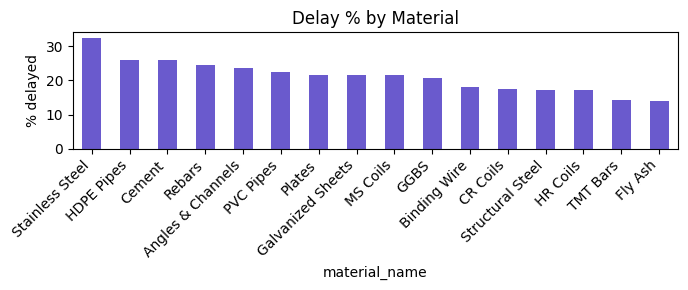

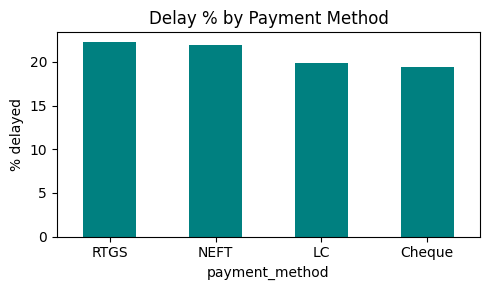

In [8]:
# 01_eda.ipynb — Block 5
# delay % by material and payment method

# delay % by material
mat = invoices.groupby("material_name")["delayed_flag"].mean().sort_values(ascending=False) * 100

# delay % by payment method
pay = invoices.groupby("payment_method")["delayed_flag"].mean().sort_values(ascending=False) * 100

print("Delay % by material:")
display(mat.round(2).to_frame("delay_%"))

print("\nDelay % by payment method:")
display(pay.round(2).to_frame("delay_%"))

# plot materials
plt.figure(figsize=(7,3))
mat.plot(kind="bar", color="slateblue")
plt.title("Delay % by Material")
plt.ylabel("% delayed")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "delay_by_material.png", dpi=150)
plt.show()

# plot payment methods
plt.figure(figsize=(5,3))
pay.plot(kind="bar", color="teal")
plt.title("Delay % by Payment Method")
plt.ylabel("% delayed")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / "delay_by_payment_method.png", dpi=150)
plt.show()


Delay % by invoice amount decile:


C:\Users\hp\AppData\Local\Temp\ipykernel_8292\464159223.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amt_delay = invoices.groupby("amount_bin")["delayed_flag"].mean() * 100


,delay_%
amount_bin,
"(49219.999, 129873.7]",16.11
"(129873.7, 168658.8]",20.00
"(168658.8, 204004.6]",21.67
"(204004.6, 238723.2]",19.44
"(238723.2, 286260.0]",20.00
"(286260.0, 332286.4]",16.67
"(332286.4, 390516.3]",27.22
"(390516.3, 481519.4]",22.22
"(481519.4, 696404.1]",25.56


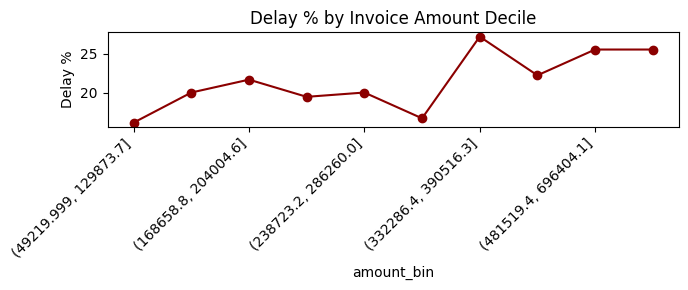

In [9]:
# 01_eda.ipynb — Block 6
# does larger invoice size correlate with higher chance of delay?

# create deciles of invoice amount
invoices["amount_bin"] = pd.qcut(invoices["invoice_amount"], q=10, duplicates="drop")

amt_delay = invoices.groupby("amount_bin")["delayed_flag"].mean() * 100

print("Delay % by invoice amount decile:")
display(amt_delay.round(2).to_frame("delay_%"))

# plot
plt.figure(figsize=(7,3))
amt_delay.plot(marker="o", color="darkred")
plt.title("Delay % by Invoice Amount Decile")
plt.ylabel("Delay %")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "delay_by_amount_decile.png", dpi=150)
plt.show()
